## Let's train an MLP using JAX

In [1]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import random
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

Note: zip(list[:-1],list[1:]) creates pair of elements from the list <br>
<br>
For example if list = [1, 128, 128, 1]<br>
zip(list[:-1],list[1:]) = zip( [1, 128, 128], [128, 128, 1] )<br>
Result will be (1,128), (128, 128), (128,1)

In [2]:
def init_mlp_params(layer_widths):
    params = []

    # Allocates weights and biases (model parameters)
    # Notice: we are not using JAX's PRNG here - it wont matter for this example
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights = np.random.normal(size=(n_in, n_out))*np.sqrt(2/n_in),
            biases = np.ones(shape=(n_out,))
            )
        )

    return params

Multiplying by sqrt(2/n_in) is "He Initialization"<br>
It's a clever trick used to train NNs better<br>
If initially weights too large -> Large output (Exploding Activations)<br>
If initially weights too small -> Small output (Vanishing Activations)<br><br>
By multiplying by that value, we aim to keep the variance stable<br>
If there are more inputs -> The weights will be smaller<br>
If there are less inputs -> The weights will be larger

In [3]:
# Instantiate a single input - single output, 3 layer (2 hidden) deep MLP
params = init_mlp_params([1, 128, 128, 1])

In [4]:
# Another example of how we might use tree.map: To verify the shapes make sense
jax.tree.map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

#### The above function creates the initial state in a way that:
- Is explicit
- Can be passed as function arguments
- Works with JAX Transforms
- Can be organized as a PyTree for easy manipulation

In [ ]:
def forward(params, x):
    *hidden, last = params
    # Separates the output layer and stores it in last

    # loop through each hidden layer
    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])
    
    # Output Layer Operations
    return jnp.dot(x, last['weights']) + last['biases']

In [6]:
def loss_fn(params, x, y):
    # MSE Loss
    return jnp.mean((forward(params, x)-y)**2)

In [ ]:
lr = 0.0001

@jit        # Notice how we jit at highest level - XLA will have plenty of space to optimize
def update(params, x, y):

    # Note that grads is a pytree with same structure as params (which is a pytree)
    # grad is one of the many JAX functions that has built-in support for PyTrees
    grads = jax.grad(loss_fn)(params, x, y)

    return jax.tree.map(
        lambda p, g: p-lr*g, params, grads
        # p , g = params, grads
        # for every leaf i.e. for every param of MLP
        # we update the parameters
    )

In [8]:
# Let's learn how to regress a parabola
xs = np.random.normal(size=(128,1))
ys = xs**2

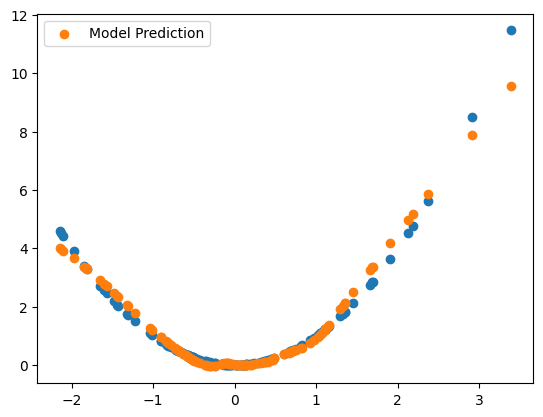

In [9]:
epochs = 5000
for _ in range(epochs):
    params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label="Model Prediction")
plt.legend()

#### Another function

In [21]:
xs = np.random.normal(size=(128,1))
ys =  np.sin(3*xs)

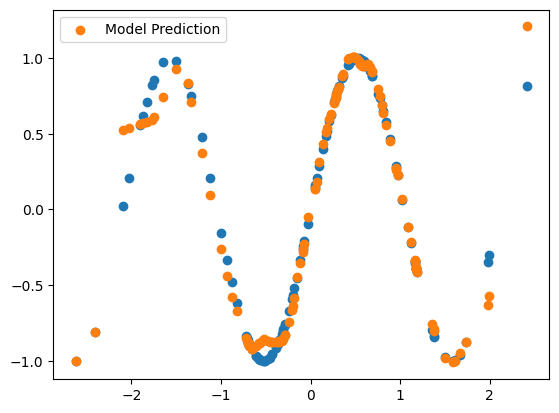

In [22]:
epochs = 5000
for _ in range(epochs):
    params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label="Model Prediction")
plt.legend()
plt.savefig('jax_mlp_pred_sin.png')

#### We have trained our first NN!

#### In order to be able to build NN libs and layers such as NN.Linear, we need a couple more tricks up our sleeve!